# Confidence Intervals In The Digits Dataset

This notebook illustrates finding confidence intervals in the Digits dataset.

The main point it shows is using ``pandas`` structures throughout the code, as well as the ease of creating pipelines using the ``|`` operator.

## Loading The Data 

First we load the dataset into a ``pandas.DataFrame``.

In [5]:
import multiprocessing

import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.externals import joblib

from ibex.sklearn import decomposition as pd_decomposition
from ibex.sklearn import linear_model as pd_linear_model
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn.model_selection import GridSearchCV as PDGridSearchCV


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
digits = datasets.load_digits()
features = ['f%d' % i for i in range(digits['data'].shape[1])]
digits = pd.DataFrame(
    np.c_[digits['data'], digits['target']], 
    columns=features+['digit'])
digits.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f55,f56,f57,f58,f59,f60,f61,f62,f63,digit
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


## Finding The Prediction Score

Following the sickit-learn example, we now pipe the PCA step to a logistic regressor.

In [7]:
clf = pd_decomposition.PCA() | pd_linear_model.LogisticRegression()

We now find the optimal fit parameters using grid-search CV.

In [8]:
estimator = PDGridSearchCV(                                                 
    clf,                                                                    
    {'pca__n_components': [20, 40, 64], 'logisticregression__C': np.logspace(-4, 4, 3)},
    n_jobs=multiprocessing.cpu_count())
estimator.fit(digits[features], digits.digit) 

AttributeError: Can't pickle local object 'make_xy_estimator.<locals>._Adapter'

It is interesting to look at the best parameters and the best score:

In [9]:
params = estimator._cv.best_estimator_.get_params()
params['pca__n_components'], params['logisticregression__C']

(40, 1.0)

In [10]:
estimator._cv.best_score_

0.92209237618252649

However, how significant is the improvement in the score?

Using the parameters found in the grid-search CV, we perform 1000 jacknife (leave 15% out) iterations.

In [11]:
def calc_cv_score(clf):
    tr = digits.sample(replace=False, frac=0.85)
    te = digits.ix[[i for i in digits.index if i not in tr.index]]
    s = clf.fit(tr[features], tr.digit).score(te[features], te.digit)
    print('_')
    return s

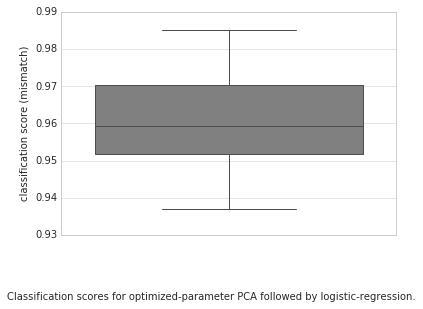

In [13]:
b = 100

clf = estimator.best_estimator_

all_scores = []
s = time.time()
for _ in range(b):
    tr = digits.sample(replace=False, frac=0.85)
    te = digits.ix[[i for i in digits.index if i not in tr.index]]
    all_scores.append(
        clf.fit(tr[features], tr.digit).score(te[features], te.digit))
    
sns.boxplot(x=all_scores, color='grey', orient='v');
ylabel('classification score (mismatch)')
figtext(
    0, 
    -0.1, 
    'Classification scores for optimized-parameter PCA followed by logistic-regression.');

    Using just logistic regression (which is much faster), we do the same.

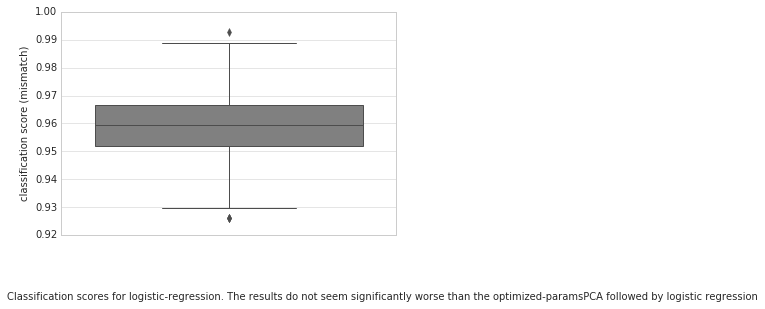

In [14]:
clf = pd_linear_model.LogisticRegression()

b = 1000

all_scores = []
for _ in range(b):
    tr = digits.sample(replace=False, frac=0.85)
    te = digits.ix[[i for i in digits.index if i not in tr.index]]
    all_scores.append(
        clf.fit(tr[features], tr.digit).score(te[features], te.digit))

sns.boxplot(x=all_scores, color='grey', orient='v');
ylabel('classification score (mismatch)')
figtext(
    0, 
    -0.1, 
    'Classification scores for logistic-regression. The results do not seem significantly worse than the optimized-params' + 
        'PCA followed by logistic regression');